In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten

from keras import optimizers
from keras.models import load_model

Using TensorFlow backend.


In [0]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import keras.backend as K
K.set_floatx('float16')

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17431980326776133540
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4784699049997087865
physical_device_desc: "device: XLA_CPU device"
]


## DATA

In [0]:
random_seed = 0
np.random.seed(random_seed)
plt.style.use('ggplot')

In [0]:
def readData(fileName):
  all_lines = []

  with open(fileName,"r") as f:
      for line in f:
          try:
              one_meas = line.split()
              if (len(one_meas)==6):
                  all_lines.append(one_meas)
          except:
              print(line)

  all_lines = np.array(all_lines,dtype=np.float)
  return all_lines

In [0]:
def windows(length,size):
    start = 0
    while start< length:
        yield int(start), int(start + size)
        start+= (size/2)
        
def segment_signal(data, window_size ,class_number,num_classes):
    segments = np.empty((0,window_size,data.shape[1]))

    for (start, end) in windows(data.shape[0],window_size):

        data_segment = data[start:end,:][None,...]

        if(len(data[start:end,:])==window_size):
            segments = np.vstack([segments,data_segment])
    # label = np.array([class_number]*segments.shape[0])
    label = np.zeros((segments.shape[0],num_classes))
    label[:,class_number]=1
    return segments,label

In [8]:
rest_raw = readData("dataset_pokoy.txt")
walking_raw = readData("dataset_xodba.txt")
squats_raw = readData("dataset_prisedanya.txt")
jumps_raw = readData("dataset_jumps.txt")
rotations_raw = readData("dataset_povorot.txt")
print("rest raw shape: ",rest_raw.shape[0])
print("walking raw shape: ",walking_raw.shape[0])
print("squats raw shape: ",squats_raw.shape[0])
print("jumps raw shape: ",jumps_raw.shape[0])
print("rotations raw shape: ",rotations_raw.shape[0])

rest raw shape:  22499
walking raw shape:  31179
squats raw shape:  25762
jumps raw shape:  29356
rotations raw shape:  24678


In [9]:
rest_signal, rest_lable = segment_signal(rest_raw,90,0,5) 
walking_signal, walking_lable = segment_signal(walking_raw,90,1,5) 
squats_signal, squats_lable = segment_signal(squats_raw,90,2,5)
jumps_signal, jumps_lable = segment_signal(jumps_raw,90,3,5)
rotations_signal, rotations_lable = segment_signal(rotations_raw,90,4,5)
print(rest_signal.shape)
print(rest_lable.shape)

(498, 90, 6)
(498, 5)


In [10]:
segments = np.vstack((rest_signal,walking_signal,squats_signal,jumps_signal,rotations_signal))
labels = np.vstack((rest_lable,walking_lable,squats_lable,jumps_lable,rotations_lable))
print(segments.shape)
print(labels.shape)

(2958, 90, 6)
(2958, 5)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.25,shuffle=True, random_state=42)

## NETWORK

In [0]:
def RNN_Model(hid_dim=64,lr=0.001):
    model = Sequential()
    # (bs, 90, 6)
    model.add(LSTM(hid_dim,input_shape=(90, 6),return_sequences=True))
    # (bs, 90, hid_dim)
    model.add(Flatten())
    # (bs, 90, hid_dim)
    model.add(Dense(5, activation='softmax'))

    # Compiling the model to generate a model
    adam = optimizers.Adam(lr = lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

## TRAIN

In [0]:
checkpoint = ModelCheckpoint('model-epoch={epoch}-acc={val_accuracy:.3f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')

In [14]:
model = RNN_Model(hid_dim=4)
print('model contains {} parametrs'.format(model.count_params()))
print('model data type {}'.format(tf.keras.backend.floatx()))
for layer in model.layers:
    print(layer.name)
history = model.fit(X_train,y_train, validation_split=0.1,epochs=100,batch_size=16,verbose=2,callbacks=[checkpoint])
score = model.evaluate(X_test,y_test,verbose=2)
print('Baseline Error: %.2f%%' %(100-score[1]*100))

model contains 1981 parametrs
model data type float16
lstm_1
flatten_1
dense_1
Train on 1996 samples, validate on 222 samples
Epoch 1/100
 - 5s - loss: 1.6448 - accuracy: 0.4204 - val_loss: 1.2123 - val_accuracy: 0.5317

Epoch 00001: val_accuracy improved from -inf to 0.53174, saving model to model-epoch=1-acc=0.532.h5
Epoch 2/100
 - 5s - loss: 1.0888 - accuracy: 0.5874 - val_loss: 0.9504 - val_accuracy: 0.6396

Epoch 00002: val_accuracy improved from 0.53174 to 0.63965, saving model to model-epoch=2-acc=0.640.h5
Epoch 3/100
 - 5s - loss: 0.8780 - accuracy: 0.6641 - val_loss: 0.8075 - val_accuracy: 0.7070

Epoch 00003: val_accuracy improved from 0.63965 to 0.70703, saving model to model-epoch=3-acc=0.707.h5
Epoch 4/100
 - 5s - loss: 0.7783 - accuracy: 0.7236 - val_loss: 0.7681 - val_accuracy: 0.6938

Epoch 00004: val_accuracy did not improve from 0.70703
Epoch 5/100
 - 5s - loss: 0.7003 - accuracy: 0.7686 - val_loss: 0.6949 - val_accuracy: 0.7119

Epoch 00005: val_accuracy improved fro

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


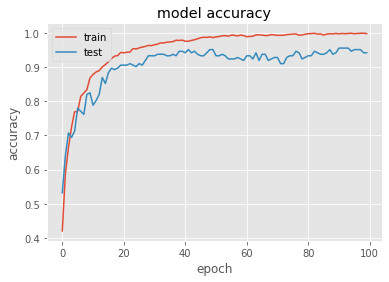

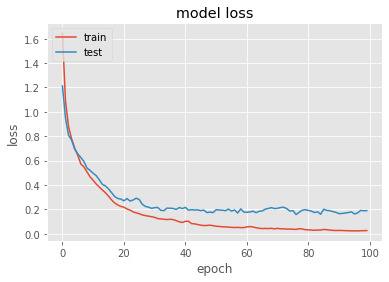

In [15]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Analysis

In [0]:
def plot_cm(cM, labels,title):
    # normalizing the confusionMatrix for showing the probabilities
    cmNormalized = np.around((cM/cM.sum(axis=1)[:,None])*100,2)
    # creating a figure object
    fig = plt.figure()
    # plotting the confusion matrix
    plt.imshow(cmNormalized,interpolation=None,cmap = plt.cm.Blues)
    # creating a color bar and setting the limits
    plt.colorbar()
    plt.clim(0,100)
    # assiging the title, x and y labels
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.title(title + '\n%age confidence')
    # defining the ticks for the x and y axis
    plt.xticks(range(len(labels)),labels,rotation = 60)
    plt.yticks(range(len(labels)),labels)
    # number of occurences in the boxes
    width, height = cM.shape
    print('Accuracy for each class is given below.')
    for predicted in range(width):
        for real in range(height):
            color = 'black'
            if(predicted == real):
                color = 'white'
                print(labels[predicted].ljust(12)+ ':', cmNormalized[predicted,real], '%')
            plt.gca().annotate(
                    '{:d}'.format(int(cmNormalized[predicted,real])),xy=(real, predicted),
                    horizontalalignment = 'center',verticalalignment = 'center',color = color)
    # making sure that the figure is not clipped
    plt.tight_layout()
    # saving the figure
    fig.savefig(title +'.png')

In [0]:
model.save('model.h5')

In [0]:
model = load_model('model.h5')

Accuracy for each class is given below.
Rest        : 97.04 %
Walking     : 95.88 %
Squats      : 96.97 %
Jumps       : 95.12 %
Rotations   : 95.68 %


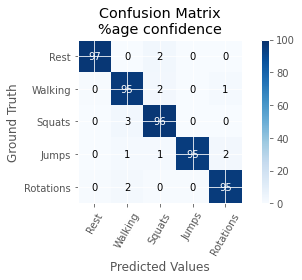

In [18]:
labels = ['Rest','Walking','Squats','Jumps','Rotations']
predictions = np.argmax(model.predict(X_test,verbose=2),axis=1)
true = np.argmax(y_test,axis=1)
# obtaining a confusion matrix
cm = metrics.confusion_matrix(true,predictions)
# plotting the confusion matrix
plot_cm(cm, labels,'Confusion Matrix')